Tiny ImageNet dataset consists of 200 categories and each category has 500 of 64x64 size images in training set.

In [3]:
# SIFT
!pip install opencv-contrib-python==4.4.0.44
# restart runtime !

     |████████████████████████████████| 55.7 MB 49 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


## Load Tiny ImageNet DataSet

In [2]:
from google.colab import drive

drive.mount( '/content/drive')

Mounted at /content/drive


In [3]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 32.21 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


## Extract test and training data from Tiny ImageNet DataSet

In [4]:
import time
import scipy.ndimage as nd
import numpy as np
from imageio import imread

path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imread( path + 'val/images/{}'.format(img_name), pilmode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data
finished loading data, in 42.247005462646484 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


## Shuffle and fit generator

In [5]:
# TinyIageNet has 200 classes
N_CLASSES = 200
CLASSES = range(200)
# our input dimensions
INSHAPE = 64, 64, 3
PICTURE_SHAPE = INSHAPE[0], INSHAPE[1]
BATCH_SIZE = 64
batches = [k*(len(train_data)//BATCH_SIZE) for k in range(BATCH_SIZE+1)]
batches.append(len(train_data))
print(batches)
batches_test = [k*(len(test_data)//BATCH_SIZE) for k in range(BATCH_SIZE+1)]
batches_test.append(len(test_data))
print(batches_test)

[0, 1562, 3124, 4686, 6248, 7810, 9372, 10934, 12496, 14058, 15620, 17182, 18744, 20306, 21868, 23430, 24992, 26554, 28116, 29678, 31240, 32802, 34364, 35926, 37488, 39050, 40612, 42174, 43736, 45298, 46860, 48422, 49984, 51546, 53108, 54670, 56232, 57794, 59356, 60918, 62480, 64042, 65604, 67166, 68728, 70290, 71852, 73414, 74976, 76538, 78100, 79662, 81224, 82786, 84348, 85910, 87472, 89034, 90596, 92158, 93720, 95282, 96844, 98406, 99968, 100000]
[0, 156, 312, 468, 624, 780, 936, 1092, 1248, 1404, 1560, 1716, 1872, 2028, 2184, 2340, 2496, 2652, 2808, 2964, 3120, 3276, 3432, 3588, 3744, 3900, 4056, 4212, 4368, 4524, 4680, 4836, 4992, 5148, 5304, 5460, 5616, 5772, 5928, 6084, 6240, 6396, 6552, 6708, 6864, 7020, 7176, 7332, 7488, 7644, 7800, 7956, 8112, 8268, 8424, 8580, 8736, 8892, 9048, 9204, 9360, 9516, 9672, 9828, 9984, 10000]


In [6]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd 
import tensorflow as tf
import os
import random

# fix random seed for involved libraries
random_seed = 4321
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

def shuffle_data(train_data, train_labels ):
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    return train_data[train_idx], train_labels[train_idx]

image_gen = ImageDataGenerator() #rescale?

train_data, train_labels = shuffle_data(train_data, train_labels)

train_gen = image_gen.flow(train_data, train_labels,
    batch_size=BATCH_SIZE, shuffle=True, seed=random_seed)

##Useful functions and imports

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from PIL import Image

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn import neighbors
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm

from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import cv2
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def int_labels(labels):
    l = []
    for label in labels:
      for j in range(len(label)):
        if label[j]==1:
          l.append(j)
          break
    return l

scaler = None
def create_scaling(X):
    global scaler
    scaler = StandardScaler().fit(X)

def create_perceptron(train_gen, prepro):
    clf = Perceptron()
    batch = 0
    for x_batch, y_batch in train_gen:
        batch += 1
        x, y = prepro(x_batch, y_batch)
        clf.partial_fit(x, int_labels(y), classes=CLASSES)
        if batch >= len(batches):
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    return clf

def create_rnd_forrest(train_gen, prepro, **kwargs):
    batch = 0
    weights = {} 
    for i in CLASSES:
        weights[i]=1
    clf = RandomForestClassifier(warm_start=True, class_weight=weights, **kwargs)
    for x_batch, y_batch in train_gen:
        batch += 1
        x, y = prepro(x_batch, y_batch)
        clf.partial_fit(x, int_labels(y), classes=CLASSES)
        if batch >= len(batches):
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    return clf

def create_nb(train_gen, prepro):
    clf =MultinomialNB()
    batch = 0
    for x_batch, y_batch in train_gen:
        batch += 1
        x, y = prepro(x_batch, y_batch)
        clf.partial_fit(x, int_labels(y), classes=CLASSES)
        if batch >= len(batches):
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    return clf
    
def create_MLP(train_gen, prepro, input_size):
    model = Sequential()
    model.add(Dense(256, activation="relu", input_shape=(input_size,)))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(200, activation="softmax"))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    for e in range(15):
        print('Epoch ', e)
        batch = 0
        for x_batch, y_batch in train_gen:
            x, y = prepro(x_batch, y_batch)
            model.fit(x, y, verbose=0)
            batch += 1
            if batch >= len(batches):
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
    return model
    
def get_metrics(algo, test_data, test_target, train_data, train_target):
    pred_test  = algo.predict(test_data)
    pred_train = algo.predict(train_data)

    return classification_report(test_target, pred_test,output_dict=True),\
           classification_report(train_target, pred_train,output_dict=True)

plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix_TIN(cm,
                          title='Confusion matrix',
                          cmap=plt.cm.jet,
                          saveas="confmat"):
    figure = plt.figure(1, figsize= (8, 8))
    ticks=[0, 50, 100, 150, 199]
    plt.imshow(cm, interpolation='none',cmap=cmap)
    plt.clim(0, 50)
    plt.colorbar()
    plt.xticks(ticks,fontsize=16)
    plt.yticks(ticks,fontsize=16)
    plt.tight_layout()
    plt.title(title,fontsize=16)
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)
    figure.savefig(saveas+".pdf", bbox_inches='tight')
    plt.show()

def analyze_predictions_TIN(cm):
    TP_order = np.argsort(cm.diagonal())
    labels = []
    for key, label in get_class_to_id_dict().values():
        l = label[:-1]
        if len(l) >= 15:
            l = l[:13] + '...'
        labels.append(l)
    labels = np.array(labels)

    print("\n least correct predictions")
    df_wrong = pd.DataFrame(zip(labels[TP_order[:10]], cm.diagonal()[TP_order[:10]]),
                   columns =['label', 'times correct predicted'])
    display(df_wrong)

    print("\n most correct predictions, labels, times correct predicted:")
    df_correct = pd.DataFrame(zip(labels[TP_order[-10:]], cm.diagonal()[TP_order[-10:]]),
                   columns =['label', 'times correct predicted'])
    display(df_correct)

    print("\n most confused labels:")
    cm_nodiag = cm-np.diag(cm.diagonal())
    ind = np.unravel_index(np.argsort(cm_nodiag, axis=None), cm_nodiag.shape)
    conf_labels = []
    for n in range(1,11):
        conf_labels.append([cm_nodiag[ind[0][-n],ind[1][-n]], labels[ind[0][-n]], labels[ind[1][-n]] ])
    df_conf = pd.DataFrame(conf_labels,
                   columns =['times confused', 'actual label', 'predicted label'])
    display(df_conf)

    print("\n biggest std for column (for which classes the cnn was not very percice):")
    ind_std = np.argsort(  (cm_nodiag + np.diag(cm_nodiag.mean(axis=0))).std(axis=0) )
    df_unsure = pd.DataFrame(labels[ind_std[-10:]],
                   columns =['times label']).T
    display(df_unsure)

    print(pd.concat([df_wrong, df_correct, df_conf], axis=1).to_latex(index=False))

In [8]:
times = {}
times_prepro = {}
times_test = {}

#Histograms

In [88]:
mask= None
histSize = [256] # Number of bins, forr full scale take 256
ranges= [0,256] # this is our RANGE. Normally, it is [0,256].

def histo(train_data, y): 

  times_prepro['histogram'] = time()
  data=[]
  for i in range(0,len(train_data)):
      hist=np.empty((0,0))
      images = train_data[i]
      #imagePIL = imagePIL.convert('RGB')   
      #images = imagePIL.convert('RGB') 
      hist_blue=cv2.calcHist(images, [0], mask, histSize, ranges)
      hist_green=cv2.calcHist(images, [1], mask, histSize, ranges)
      hist_red=cv2.calcHist(images, [2], mask, histSize, ranges)
      hist = np.append(hist, hist_blue)
      hist = np.append(hist, hist_green)
      hist = np.append(hist, hist_red)
      featureVector=hist
      #if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
      #    print("Unexpected length of feature vector: " + i)
      data.append((featureVector))
  np_data=np.array(data)
  times_prepro['histogram'] = time() - times_prepro['histogram']
  return np_data, y

In [89]:
def histo_1D(train_data, y):

  times_prepro['histogram 1D'] = time()

  # use our own simple function to flatten the 2D arrays
  flatten = lambda l: [item for sublist in l for item in sublist]
  dataOpenCV_1D = []

  for i in range(0,len(train_data)):
      featuresOpenCV_1D = []
      #hist=np.empty((0,0))
      images = train_data[i]
      
      channels= ([0], [1], [2])
      color = ("b", "g", "r")
      
      histSize_1d=[64] 
      featuresOpenCV_1D = []
      for (channels, color) in zip(channels,color):
          
          # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
          # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
          #imagePIL = imagePIL.convert('RGB')   
          #images = imagePIL.convert('RGB') 
          hist_opencv=cv2.calcHist(images, channels, mask, histSize_1d, ranges)
          featuresOpenCV_1D=np.append(featuresOpenCV_1D, hist_opencv)
      featureVectorOpenCV_1D = featuresOpenCV_1D
      dataOpenCV_1D.append(featureVectorOpenCV_1D) 
      
      #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
      #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
      
  times_prepro['histogram 1D'] = time() - times_prepro['histogram 1D']
  return np.array(dataOpenCV_1D), y

In [90]:
def histo_2D(train_data, y):

  times_prepro['histogram 2D'] = time()
  dataOpenCV_2D = []

  for i in range(0,len(train_data)):
      featuresOpenCV_2D = []
      #hist=np.empty((0,0))
      images = train_data[i]
      
      channels= [[0], [1], [2]]
      color = ("b", "g", "r")
      
      histSize_2d= 16 
      featuresOpenCV_2D = []
          
          # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
          # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
          #imagePIL = imagePIL.convert('RGB')   
          #images = imagePIL.convert('RGB') 
      hist_opencv_2d_1 = cv2.calcHist(images,  [0,1], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
      hist_opencv_2d_2 = cv2.calcHist(images,  [0,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
      hist_opencv_2d_3 = cv2.calcHist(images,  [1,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
      featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_1)
      featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_2)
      featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_3)
      featureVectorOpenCV_2D = featuresOpenCV_2D # and append this to our feature vector
      dataOpenCV_2D.append(featureVectorOpenCV_2D) # now we append the feature vector to the dataset so far
      
      #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
      #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
      
  np_dataOpenCV_2D= np.array(dataOpenCV_2D)
  times_prepro['histogram 2D'] = time() - times_prepro['histogram 2D']
  return np_dataOpenCV_2D, y

In [91]:
def histo_3D (train_data, y) :

  dataOpenCV_3D=[]

  times_prepro['histogram 3D'] = time()

  for i in range(0,len(train_data)):
      featuresOpenCV_2D = []
      #hist=np.empty((0,0))
      images = train_data[i]
      
      channels= [[0], [1], [2]]
      color = ("b", "g", "r")
      
      histSize_3d= 8 
      featuresOpenCV_3D = []

      #imagePIL = imagePIL.convert('RGB')   
      #images = imagePIL.convert('RGB') 
      hist_opencv_3d = cv2.calcHist(images,  [0,1,2], mask, [histSize_3d, histSize_3d,histSize_3d ], [0, 256, 0, 256,  0, 256])
      featuresOpenCV_3D= np.append(featuresOpenCV_2D, hist_opencv_3d)
      featureVectorOpenCV_3D = featuresOpenCV_3D # and append this to our feature vector
      dataOpenCV_3D.append(featureVectorOpenCV_3D) # now we append the feature vector to the dataset so far
  
  np_dataOpenCV_3D = np.array(dataOpenCV_3D)
  times_prepro['histogram 3D'] = time() - times_prepro['histogram 3D']
  return np_dataOpenCV_3D, y

#Classification

ppn trained


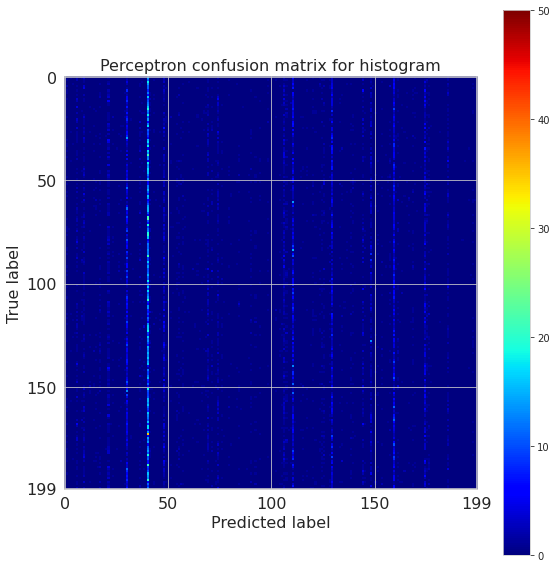


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,turnstile,0
2,scorpion,0
3,wooden spoon,0
4,"picket fence,...",0
5,rugby ball,0
6,steel arch br...,0
7,Persian cat,0
8,"refrigerator,...",0
9,barn,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,"teddy, teddy ...",2
1,"cash machine,...",2
2,"plunger, plum...",2
3,"spider web, s...",3
4,scoreboard,3
5,"orangutan, or...",4
6,chest,5
7,trilobite,6
8,pretzel,13
9,space heater,14



 most confused labels:


,times confused,actual label,predicted label
0,35,comic book,pretzel
1,22,"bullet train,...",pretzel
2,21,bell pepper,pretzel
3,21,"backpack, bac...",pretzel
4,21,"koala, koala ...",pretzel
5,21,bee,pretzel
6,20,"miniskirt, mi...",pretzel
7,20,acorn,pretzel
8,20,"jinrikisha, r...",pretzel
9,19,"pizza, pizza ...",pretzel



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,"cash machine,...","teddy, teddy ...","cockroach, ro...",scoreboard,trilobite,sewing machine,"orangutan, or...",space heater,chest,pretzel


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label & predicted label \\
\midrule
     Egyptian cat &                        0 &  teddy, teddy ... &                        2 &              35 &        comic book &         pretzel \\
        turnstile &                        0 &  cash machine,... &                        2 &              22 &  bullet train,... &         pretzel \\
         scorpion &                        0 &  plunger, plum... &                        2 &              21 &       bell pepper &         pretzel \\
     wooden spoon &                        0 &  spider web, s... &                        3 &              21 &  backpack, bac... &         pretzel \\
 picket fence,... &                        0 &        scoreboard &                        3 &              21 &  koala, koala ... &         pretzel \\
       rugby ball &                        0 &  ora

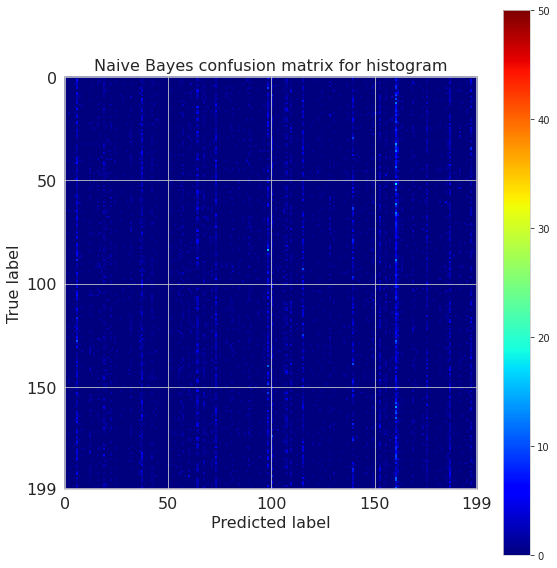


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,suspension br...,0
2,ox,0
3,"ice lolly, lo...",0
4,turnstile,0
5,Christmas sto...,0
6,broom,0
7,scorpion,0
8,wooden spoon,0
9,water jug,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,basketball,4
1,water tower,4
2,slug,4
3,"black stork, ...",4
4,moving van,5
5,pill bottle,5
6,"sea cucumber,...",6
7,gazelle,7
8,"thatch, thatc...",10
9,American alli...,14



 most confused labels:


,times confused,actual label,predicted label
0,18,freight car,American alli...
1,15,"candle, taper...",pill bottle
2,14,snail,American alli...
3,13,torch,American alli...
4,12,spiny lobster...,American alli...
5,12,"tabby, tabby ...",American alli...
6,12,"spider web, s...",American alli...
7,12,"monarch, mona...",American alli...
8,11,"lesser panda,...",American alli...
9,11,standard pood...,American alli...



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,"sea cucumber,...",obelisk,moving van,gazelle,slug,"black stork, ...",basketball,"thatch, thatc...",pill bottle,American alli...


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label &   predicted label \\
\midrule
     Egyptian cat &                        0 &        basketball &                        4 &              18 &       freight car &  American alli... \\
 suspension br... &                        0 &       water tower &                        4 &              15 &  candle, taper... &       pill bottle \\
               ox &                        0 &              slug &                        4 &              14 &             snail &  American alli... \\
 ice lolly, lo... &                        0 &  black stork, ... &                        4 &              13 &             torch &  American alli... \\
        turnstile &                        0 &        moving van &                        5 &              12 &  spiny lobster... &  American alli... \\
 Christmas sto... &                    

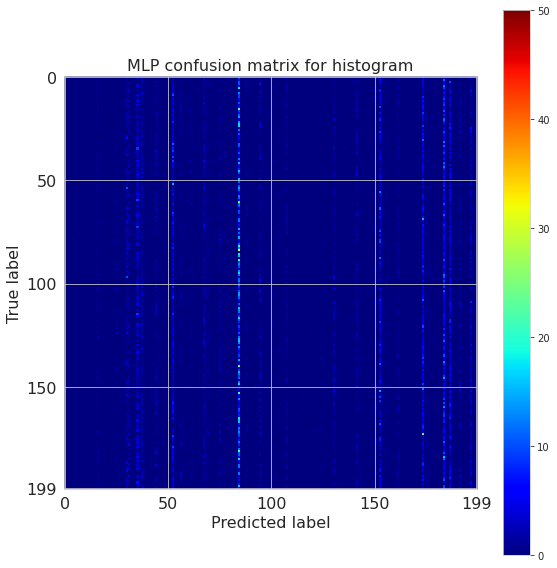


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,"ice lolly, lo...",0
2,turnstile,0
3,Christmas sto...,0
4,broom,0
5,scorpion,0
6,wooden spoon,0
7,"picket fence,...",0
8,rugby ball,0
9,sewing machine,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,"black widow, ...",3
1,obelisk,3
2,"tailed frog, ...",6
3,lifeboat,6
4,space heater,7
5,"albatross, mo...",9
6,"trolleybus, t...",14
7,freight car,15
8,comic book,22
9,"candle, taper...",31



 most confused labels:


,times confused,actual label,predicted label
0,22,"lampshade, la...","candle, taper..."
1,22,fountain,"candle, taper..."
2,22,"pizza, pizza ...","candle, taper..."
3,21,drumstick,"candle, taper..."
4,21,walking stick...,"candle, taper..."
5,20,spiny lobster...,"candle, taper..."
6,20,sombrero,"candle, taper..."
7,18,"sea slug, nud...","candle, taper..."
8,18,basketball,"candle, taper..."
9,18,"frying pan, f...","candle, taper..."



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,jellyfish,lifeboat,space heater,"albatross, mo...",obelisk,freight car,comic book,"trolleybus, t...","tailed frog, ...","candle, taper..."


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label &   predicted label \\
\midrule
     Egyptian cat &                        0 &  black widow, ... &                        3 &              22 &  lampshade, la... &  candle, taper... \\
 ice lolly, lo... &                        0 &           obelisk &                        3 &              22 &          fountain &  candle, taper... \\
        turnstile &                        0 &  tailed frog, ... &                        6 &              22 &  pizza, pizza ... &  candle, taper... \\
 Christmas sto... &                        0 &          lifeboat &                        6 &              21 &         drumstick &  candle, taper... \\
            broom &                        0 &      space heater &                        7 &              21 &  walking stick... &  candle, taper... \\
         scorpion &                    

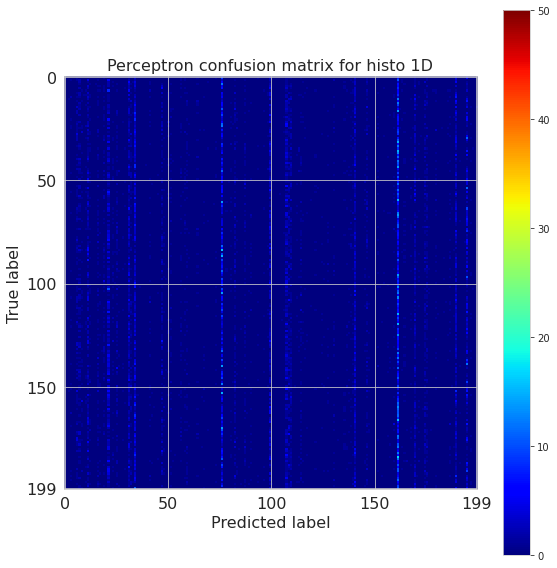


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,"ice lolly, lo...",0
2,turnstile,0
3,Christmas sto...,0
4,broom,0
5,scorpion,0
6,wooden spoon,0
7,"picket fence,...",0
8,rugby ball,0
9,sewing machine,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,"bannister, ba...",2
1,"butcher shop,...",3
2,military unif...,3
3,standard pood...,4
4,cardigan,5
5,"jinrikisha, r...",5
6,maypole,6
7,coral reef,7
8,"ladybug, lady...",8
9,centipede,11



 most confused labels:


,times confused,actual label,predicted label
0,17,"lion, king of...",centipede
1,16,cliff dwelling,centipede
2,16,"candle, taper...","ladybug, lady..."
3,15,ox,centipede
4,15,bee,"ladybug, lady..."
5,15,"black stork, ...",centipede
6,15,alp,centipede
7,15,drumstick,"ladybug, lady..."
8,15,"spider web, s...",centipede
9,15,baboon,centipede



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,fountain,German shephe...,mushroom,"butcher shop,...","bannister, ba...",maypole,coral reef,standard pood...,"ladybug, lady...",centipede


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label &   predicted label \\
\midrule
     Egyptian cat &                        0 &  bannister, ba... &                        2 &              17 &  lion, king of... &         centipede \\
 ice lolly, lo... &                        0 &  butcher shop,... &                        3 &              16 &    cliff dwelling &         centipede \\
        turnstile &                        0 &  military unif... &                        3 &              16 &  candle, taper... &  ladybug, lady... \\
 Christmas sto... &                        0 &  standard pood... &                        4 &              15 &                ox &         centipede \\
            broom &                        0 &          cardigan &                        5 &              15 &               bee &  ladybug, lady... \\
         scorpion &                    

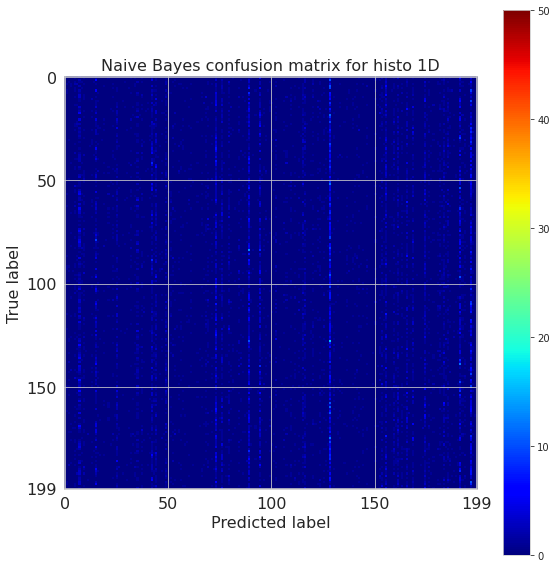


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,water jug,0
2,suspension br...,0
3,"ice lolly, lo...",0
4,turnstile,0
5,Christmas sto...,0
6,broom,0
7,scorpion,0
8,wooden spoon,0
9,"sports car, s...",0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,gazelle,4
1,"seashore, coa...",4
2,jellyfish,5
3,viaduct,5
4,"lesser panda,...",6
5,spiny lobster...,7
6,magnetic comp...,8
7,sulphur butte...,8
8,lifeboat,10
9,rugby ball,16



 most confused labels:


,times confused,actual label,predicted label
0,13,"candle, taper...",spiny lobster...
1,12,bison,rugby ball
2,12,freight car,rugby ball
3,12,"thatch, thatc...",magnetic comp...
4,11,American alli...,rugby ball
5,11,"organ, pipe o...",rugby ball
6,10,go-kart,rugby ball
7,10,remote contro...,magnetic comp...
8,10,volleyball,rugby ball
9,10,rugby ball,spiny lobster...



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,sulphur butte...,"brass, memori...","cliff, drop, ...",school bus,jellyfish,gazelle,spiny lobster...,magnetic comp...,lifeboat,rugby ball


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label &   predicted label \\
\midrule
     Egyptian cat &                        0 &           gazelle &                        4 &              13 &  candle, taper... &  spiny lobster... \\
        water jug &                        0 &  seashore, coa... &                        4 &              12 &             bison &        rugby ball \\
 suspension br... &                        0 &         jellyfish &                        5 &              12 &       freight car &        rugby ball \\
 ice lolly, lo... &                        0 &           viaduct &                        5 &              12 &  thatch, thatc... &  magnetic comp... \\
        turnstile &                        0 &  lesser panda,... &                        6 &              11 &  American alli... &        rugby ball \\
 Christmas sto... &                    

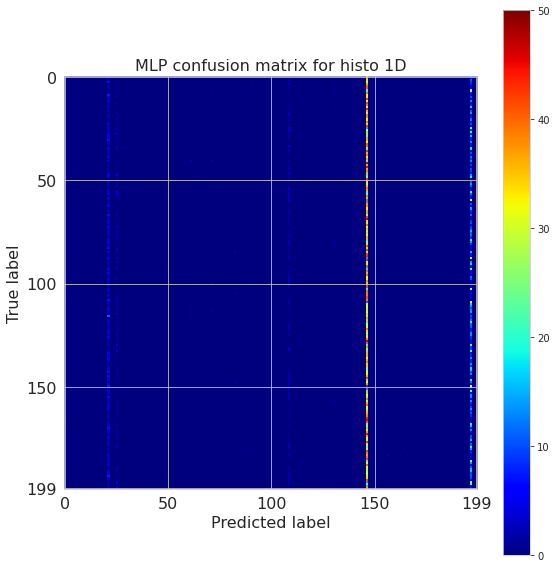


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,wooden spoon,0
2,"picket fence,...",0
3,rugby ball,0
4,sewing machine,0
5,steel arch br...,0
6,Persian cat,0
7,"refrigerator,...",0
8,apron,0
9,Yorkshire ter...,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,"koala, koala ...",0
1,"bullet train,...",0
2,CD player,0
3,teapot,0
4,"jinrikisha, r...",1
5,maypole,1
6,barn,1
7,"seashore, coa...",3
8,lifeboat,25
9,confectionery...,42



 most confused labels:


,times confused,actual label,predicted label
0,47,sulphur butte...,confectionery...
1,46,rugby ball,confectionery...
2,46,"bullet train,...",confectionery...
3,45,"lesser panda,...",confectionery...
4,45,cliff dwelling,confectionery...
5,45,comic book,confectionery...
6,44,"pizza, pizza ...",confectionery...
7,44,"sea slug, nud...",confectionery...
8,44,spiny lobster...,confectionery...
9,44,bee,confectionery...



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,brain coral,"lampshade, la...",steel arch br...,teapot,sombrero,"jinrikisha, r...","seashore, coa...",maypole,lifeboat,confectionery...


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label &   predicted label \\
\midrule
     Egyptian cat &                        0 &  koala, koala ... &                        0 &              47 &  sulphur butte... &  confectionery... \\
     wooden spoon &                        0 &  bullet train,... &                        0 &              46 &        rugby ball &  confectionery... \\
 picket fence,... &                        0 &         CD player &                        0 &              46 &  bullet train,... &  confectionery... \\
       rugby ball &                        0 &            teapot &                        0 &              45 &  lesser panda,... &  confectionery... \\
   sewing machine &                        0 &  jinrikisha, r... &                        1 &              45 &    cliff dwelling &  confectionery... \\
 steel arch br... &                    

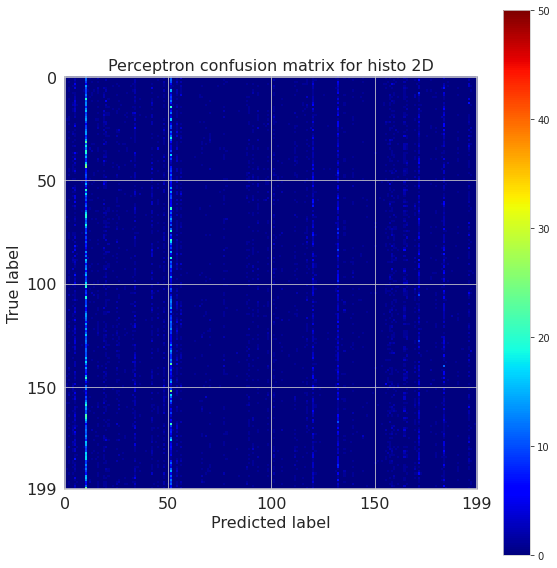


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,"ice lolly, lo...",0
2,turnstile,0
3,Christmas sto...,0
4,broom,0
5,scorpion,0
6,wooden spoon,0
7,rugby ball,0
8,sewing machine,0
9,steel arch br...,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,"cockroach, ro...",2
1,"orangutan, or...",2
2,"sports car, s...",3
3,sulphur butte...,3
4,"organ, pipe o...",3
5,computer keyb...,3
6,"refrigerator,...",3
7,ox,4
8,"mantis, mantid",7
9,parking meter,9



 most confused labels:


,times confused,actual label,predicted label
0,26,"trolleybus, t...","mantis, mantid"
1,25,"lesser panda,...",parking meter
2,24,African eleph...,parking meter
3,23,tarantula,parking meter
4,23,"thatch, thatc...","mantis, mantid"
5,23,baboon,parking meter
6,22,brain coral,parking meter
7,21,viaduct,"mantis, mantid"
8,20,"sea slug, nud...",parking meter
9,20,tractor,"mantis, mantid"



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,brain coral,acorn,coral reef,"bullfrog, Ran...",ox,chain,"tailed frog, ...","refrigerator,...",parking meter,"mantis, mantid"


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label & predicted label \\
\midrule
     Egyptian cat &                        0 &  cockroach, ro... &                        2 &              26 &  trolleybus, t... &  mantis, mantid \\
 ice lolly, lo... &                        0 &  orangutan, or... &                        2 &              25 &  lesser panda,... &   parking meter \\
        turnstile &                        0 &  sports car, s... &                        3 &              24 &  African eleph... &   parking meter \\
 Christmas sto... &                        0 &  sulphur butte... &                        3 &              23 &         tarantula &   parking meter \\
            broom &                        0 &  organ, pipe o... &                        3 &              23 &  thatch, thatc... &  mantis, mantid \\
         scorpion &                        0 &  com

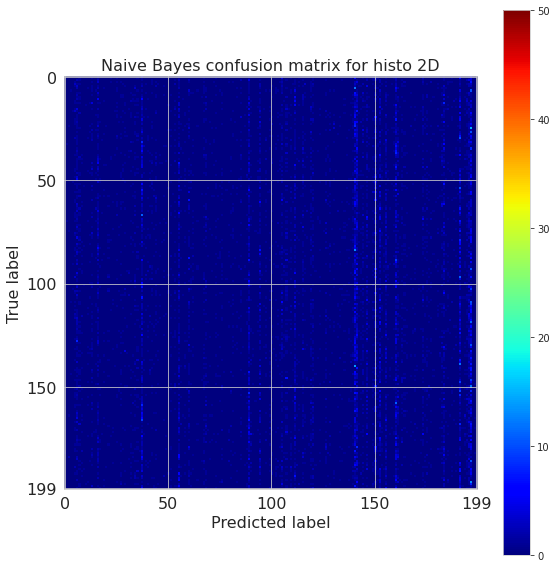


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,fly,0
2,"limousine, li...",0
3,"dugong, Dugon...",0
4,"sports car, s...",0
5,water jug,0
6,suspension br...,0
7,"ice lolly, lo...",0
8,turnstile,0
9,Christmas sto...,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,"tailed frog, ...",5
1,comic book,5
2,"trolleybus, t...",6
3,alp,7
4,magnetic comp...,7
5,"black widow, ...",7
6,spiny lobster...,7
7,"flagpole, fla...",7
8,lifeboat,13
9,fountain,14



 most confused labels:


,times confused,actual label,predicted label
0,15,"seashore, coa...",lifeboat
1,13,"candle, taper...",fountain
2,12,"thatch, thatc...",magnetic comp...
3,12,basketball,fountain
4,12,"flagpole, fla...",lifeboat
5,11,suspension br...,lifeboat
6,11,goose,"sea cucumber,..."
7,11,sandal,magnetic comp...
8,11,"bighorn, bigh...",American alli...
9,10,"cliff, drop, ...",lifeboat



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,European fire...,"tailed frog, ...","trolleybus, t...",spiny lobster...,"black widow, ...","sea cucumber,...",American alli...,fountain,magnetic comp...,lifeboat


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label &   predicted label \\
\midrule
     Egyptian cat &                        0 &  tailed frog, ... &                        5 &              15 &  seashore, coa... &          lifeboat \\
              fly &                        0 &        comic book &                        5 &              13 &  candle, taper... &          fountain \\
 limousine, li... &                        0 &  trolleybus, t... &                        6 &              12 &  thatch, thatc... &  magnetic comp... \\
 dugong, Dugon... &                        0 &               alp &                        7 &              12 &        basketball &          fountain \\
 sports car, s... &                        0 &  magnetic comp... &                        7 &              12 &  flagpole, fla... &          lifeboat \\
        water jug &                    

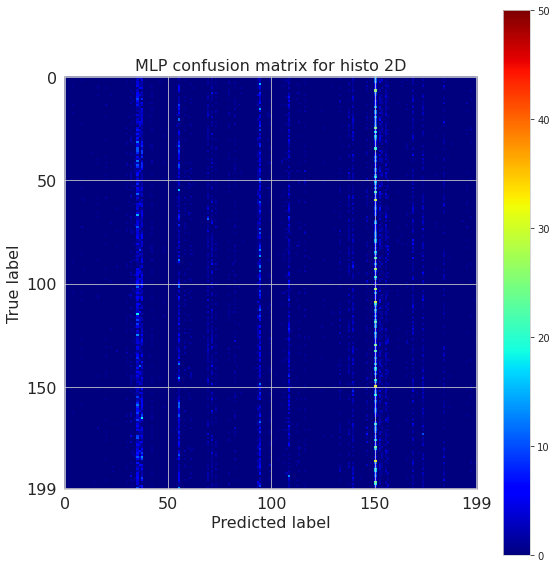


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,"ice lolly, lo...",0
2,turnstile,0
3,Christmas sto...,0
4,broom,0
5,scorpion,0
6,wooden spoon,0
7,"picket fence,...",0
8,rugby ball,0
9,sewing machine,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,viaduct,5
1,"trolleybus, t...",6
2,"jinrikisha, r...",8
3,"sea cucumber,...",9
4,"albatross, mo...",10
5,comic book,10
6,"bullet train,...",11
7,jellyfish,12
8,European fire...,16
9,"flagpole, fla...",32



 most confused labels:


,times confused,actual label,predicted label
0,32,obelisk,"flagpole, fla..."
1,30,water tower,"flagpole, fla..."
2,30,alp,"flagpole, fla..."
3,28,crane,"flagpole, fla..."
4,27,"beacon, light...","flagpole, fla..."
5,26,"cliff, drop, ...","flagpole, fla..."
6,25,"seashore, coa...","flagpole, fla..."
7,24,lifeboat,"flagpole, fla..."
8,24,steel arch br...,"flagpole, fla..."
9,23,"bathtub, bath...","flagpole, fla..."



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,viaduct,"thatch, thatc...","trolleybus, t...","spider web, s...","jinrikisha, r...","sea cucumber,...","albatross, mo...",European fire...,jellyfish,"flagpole, fla..."


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label &   predicted label \\
\midrule
     Egyptian cat &                        0 &           viaduct &                        5 &              32 &           obelisk &  flagpole, fla... \\
 ice lolly, lo... &                        0 &  trolleybus, t... &                        6 &              30 &       water tower &  flagpole, fla... \\
        turnstile &                        0 &  jinrikisha, r... &                        8 &              30 &               alp &  flagpole, fla... \\
 Christmas sto... &                        0 &  sea cucumber,... &                        9 &              28 &             crane &  flagpole, fla... \\
            broom &                        0 &  albatross, mo... &                       10 &              27 &  beacon, light... &  flagpole, fla... \\
         scorpion &                    

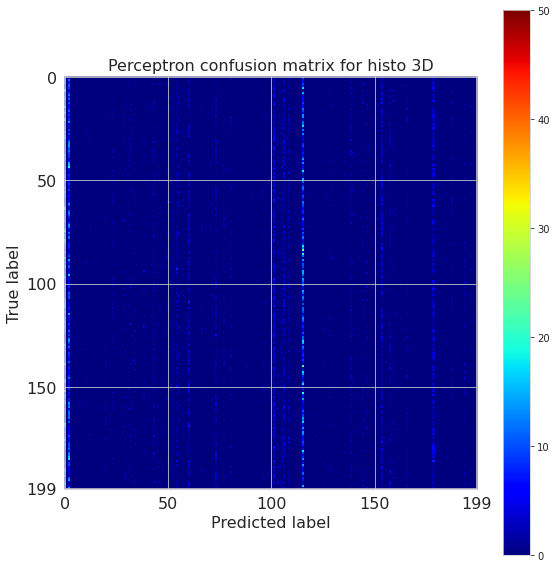


 least correct predictions


,label,times correct predicted
0,"butcher shop,...",0
1,broom,0
2,scorpion,0
3,wooden spoon,0
4,"picket fence,...",0
5,rugby ball,0
6,sewing machine,0
7,steel arch br...,0
8,Persian cat,0
9,"refrigerator,...",0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,reel,2
1,confectionery...,2
2,"backpack, bac...",2
3,drumstick,2
4,"black stork, ...",2
5,"cash machine,...",3
6,"dragonfly, da...",3
7,poncho,3
8,Egyptian cat,9
9,volleyball,12



 most confused labels:


,times confused,actual label,predicted label
0,27,"candle, taper...","black stork, ..."
1,24,"trolleybus, t...",Egyptian cat
2,23,moving van,Egyptian cat
3,21,"dam, dike, dy...",Egyptian cat
4,21,"cliff, drop, ...",Egyptian cat
5,21,fountain,"black stork, ..."
6,20,"lesser panda,...",volleyball
7,20,"thatch, thatc...",Egyptian cat
8,20,drumstick,"black stork, ..."
9,20,tractor,Egyptian cat



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,remote contro...,gazelle,"cash machine,...",drumstick,alp,poncho,"hog, pig, gru...",volleyball,Egyptian cat,"black stork, ..."


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label &   predicted label \\
\midrule
 butcher shop,... &                        0 &              reel &                        2 &              27 &  candle, taper... &  black stork, ... \\
            broom &                        0 &  confectionery... &                        2 &              24 &  trolleybus, t... &      Egyptian cat \\
         scorpion &                        0 &  backpack, bac... &                        2 &              23 &        moving van &      Egyptian cat \\
     wooden spoon &                        0 &         drumstick &                        2 &              21 &  dam, dike, dy... &      Egyptian cat \\
 picket fence,... &                        0 &  black stork, ... &                        2 &              21 &  cliff, drop, ... &      Egyptian cat \\
       rugby ball &                    

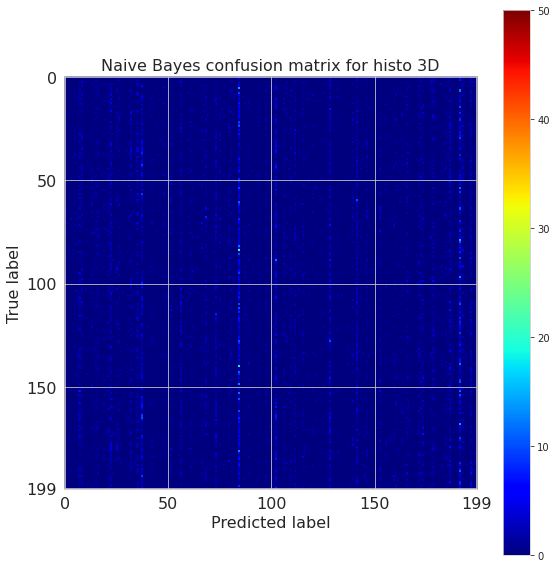


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,"limousine, li...",0
2,"dugong, Dugon...",0
3,"sports car, s...",0
4,water jug,0
5,suspension br...,0
6,ox,0
7,"ice lolly, lo...",0
8,fly,0
9,turnstile,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,"albatross, mo...",4
1,"lakeside, lak...",4
2,"trolleybus, t...",5
3,obelisk,6
4,comic book,7
5,"sea cucumber,...",8
6,"koala, koala ...",8
7,rugby ball,10
8,magnetic comp...,11
9,"candle, taper...",22



 most confused labels:


,times confused,actual label,predicted label
0,18,fountain,"candle, taper..."
1,15,triumphal arch,magnetic comp...
2,14,basketball,"candle, taper..."
3,14,viaduct,magnetic comp...
4,13,walking stick...,"candle, taper..."
5,13,sandal,magnetic comp...
6,13,orange,"candle, taper..."
7,12,sombrero,"candle, taper..."
8,12,"cliff, drop, ...",magnetic comp...
9,12,spiny lobster...,"cougar, puma,..."



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,"lakeside, lak...",gazelle,"goldfish, Car...","black widow, ...",obelisk,rugby ball,"cougar, puma,...","sea cucumber,...","candle, taper...",magnetic comp...


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label &   predicted label \\
\midrule
     Egyptian cat &                        0 &  albatross, mo... &                        4 &              18 &          fountain &  candle, taper... \\
 limousine, li... &                        0 &  lakeside, lak... &                        4 &              15 &    triumphal arch &  magnetic comp... \\
 dugong, Dugon... &                        0 &  trolleybus, t... &                        5 &              14 &        basketball &  candle, taper... \\
 sports car, s... &                        0 &           obelisk &                        6 &              14 &           viaduct &  magnetic comp... \\
        water jug &                        0 &        comic book &                        7 &              13 &  walking stick... &  candle, taper... \\
 suspension br... &                    

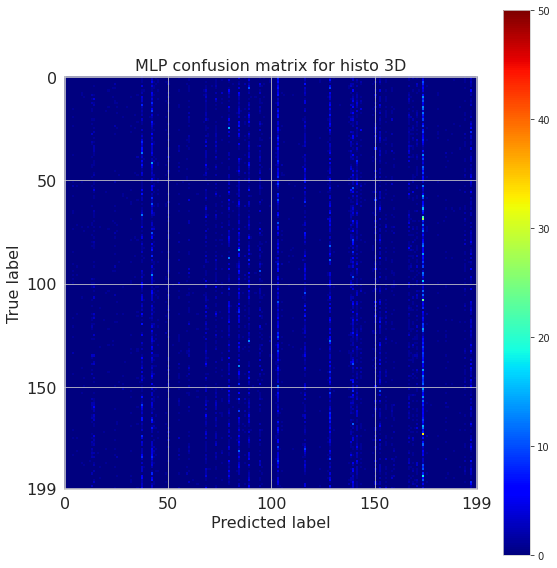


 least correct predictions


,label,times correct predicted
0,Egyptian cat,0
1,suspension br...,0
2,ox,0
3,"ice lolly, lo...",0
4,turnstile,0
5,Christmas sto...,0
6,broom,0
7,scorpion,0
8,wooden spoon,0
9,water jug,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,lifeboat,8
1,spiny lobster...,8
2,"trolleybus, t...",10
3,"thatch, thatc...",10
4,jellyfish,10
5,rugby ball,12
6,"sea cucumber,...",12
7,sulphur butte...,14
8,"candle, taper...",14
9,comic book,33



 most confused labels:


,times confused,actual label,predicted label
0,27,"bullet train,...",comic book
1,24,"jinrikisha, r...",comic book
2,21,"koala, koala ...",comic book
3,18,gondola,comic book
4,16,"butcher shop,...",comic book
5,15,military unif...,comic book
6,15,"pay-phone, pa...",comic book
7,15,moving van,comic book
8,15,"seashore, coa...",triumphal arch
9,14,turnstile,comic book



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,"dugong, Dugon...",spiny lobster...,triumphal arch,"sea cucumber,...","candle, taper...",sulphur butte...,rugby ball,"thatch, thatc...",crane,comic book


\begin{tabular}{lrlrrll}
\toprule
            label &  times correct predicted &             label &  times correct predicted &  times confused &      actual label & predicted label \\
\midrule
     Egyptian cat &                        0 &          lifeboat &                        8 &              27 &  bullet train,... &      comic book \\
 suspension br... &                        0 &  spiny lobster... &                        8 &              24 &  jinrikisha, r... &      comic book \\
               ox &                        0 &  trolleybus, t... &                       10 &              21 &  koala, koala ... &      comic book \\
 ice lolly, lo... &                        0 &  thatch, thatc... &                       10 &              18 &           gondola &      comic book \\
        turnstile &                        0 &         jellyfish &                       10 &              16 &  butcher shop,... &      comic book \\
 Christmas sto... &                        0 &     

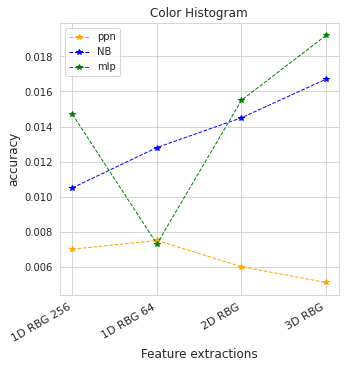

In [96]:
def calc_score_MLP(mlp, X, Y, cv, epochs, batch_size):
    kfold = KFold(n_splits=cv, shuffle=True)
    acc_per_fold = []
    for train, test in kfold.split(X, Y):
        train_data = np.take(X, train, 0)
        train_target = np.take(Y, train, 0)
        test_data = np.take(X, test, 0)
        test_target = np.take(Y, test, 0)
        history = mlp.fit(train_data, np_utils.to_categorical(train_target), batch_size=batch_size, epochs=epochs, verbose=0)
        y_pred = mlp.predict(test_data)
        #print(y_pred)
        score = accuracy_score(y_pred, test_target)
        acc_per_fold.append(score)
    return np.array(acc_per_fold)

# Classification
import warnings
warnings.filterwarnings('ignore')

# these are our feature sets; we will use each of them individually to train classifiers
prepros = [histo, histo_1D, histo_2D, histo_3D]
input_sizes = [768, 192, 768, 512]
labelTrainingSet = ['histogram', 'histo 1D', 'histo 2D', 'histo 3D']
trainingLabel=int_labels(train_labels)
scores_ppn, scores_NB, scores_rndf, scores_mlp = [], [], [], []
X_test = test_data
y_test = int_labels(test_labels)

for i in range(len(prepros)):
    prepro = prepros[i]

    times['histo ppn'] = time()
    ppn = create_perceptron(train_gen, prepro)
    times['histo ppn'] = time() - times['histo ppn']
    print('ppn trained')
    y_pred = ppn.predict(prepro(X_test, y_test)[0])
    scores_ppn.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Perceptron confusion matrix for ' + str(labelTrainingSet[i]),
                          saveas="./CM__ppn_"+str(labelTrainingSet[i]))
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    times['histo nb'] = time()
    nb = create_nb(train_gen, prepro)
    times['histo nb'] = time() - times['histo nb']
    print('nb trained')
    y_pred = nb.predict(prepro(X_test, y_test)[0])
    scores_NB.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Naive Bayes confusion matrix for ' + str(labelTrainingSet[i]),
                          saveas="./CM__nb_"+str(labelTrainingSet[i]))
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    # not online learner and very imbalanced classes so the batches with warm start do not work
    '''times['histo rndf'] = time()
    rndf = create_rnd_forrest(train_gen, prepro)
    times['histo rndf'] = time() - times['histo rndf']
    print('rndf trained')
    print(prepro(X_test).shape)
    y_pred = rndf.predict(prepro(X_test))
    scores_rndf.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Random forest confusion matrix for ' + str(labelTrainingSet[i]),
                          saveas="./CM__rndf_"+str(labelTrainingSet[i]))
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))'''

    times['histo mlp'] = time()
    mlp = create_MLP(train_gen, prepro, input_sizes[i])
    times['histo mlp'] = time() - times['histo mlp']
    print('mlp trained')
    y_pred = mlp.predict_classes(prepro(X_test, y_test)[0])
    print(y_pred)
    print(y_test)
    scores_mlp.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='MLP confusion matrix for ' + str(labelTrainingSet[i]),
                          saveas="./CM__mlp_"+str(labelTrainingSet[i]))
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))
        
print(scores_ppn)
print(scores_NB)
#print(scores_rndf)
print(scores_mlp)

Nr_data = np.arange(4)
plt.figure(figsize=(5,5))
plt.plot(Nr_data, scores_ppn,"--",color="orange",marker="*", linewidth=1,label="ppn")
plt.plot(Nr_data, scores_NB,"--",color="blue",marker="*", linewidth=1,label="NB")
#plt.plot(Nr_data, scores_rndf,"--",color="black",marker="*", linewidth=1,label="rndf")
plt.plot(Nr_data, scores_mlp,"--",color="green",marker="*", linewidth=1,label="mlp")
plt.legend(loc="best")
plt.title("Color Histogram",fontsize=12)
plt.ylabel("accuracy",fontsize=12)
plt.xlabel("Feature extractions",fontsize=12)
labels =["1D RBG 256", "1D RBG 64", "2D RBG", "3D RBG"]
plt.xticks(Nr_data, labels,rotation=30,fontsize=11, ha="right")
plt.savefig("./Accuracy_color_hist.pdf")

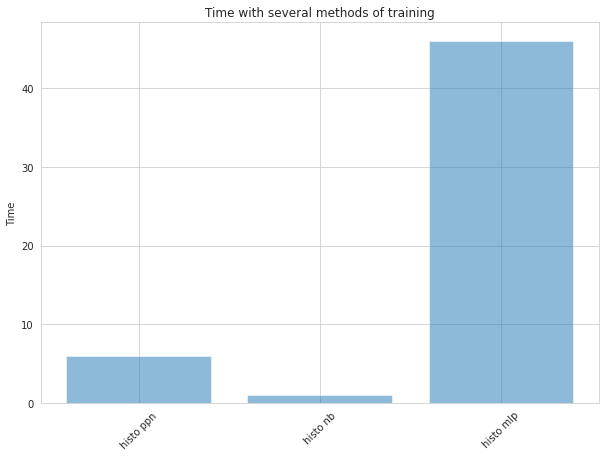

In [98]:
objects = ['histo ppn', 'histo nb', 'histo mlp']
y_pos = np.arange(len(objects))
scores = [times[val] for val in objects]

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of training')

plt.savefig("./time_training.pdf")
plt.show()

#Bag of words

In [15]:
Image_grey=cv2.cvtColor(train_data[0], cv2.COLOR_BGR2GRAY)
print(train_data[0])

[[[212  72  55]
  [207  64  48]
  [202  56  41]
  ...
  [234  84  85]
  [234  81  83]
  [232  79  81]]

 [[212  72  55]
  [208  67  50]
  [205  59  44]
  ...
  [229  86  82]
  [227  84  80]
  [224  81  77]]

 [[208  71  53]
  [208  68  51]
  [207  64  48]
  ...
  [221  89  77]
  [218  86  74]
  [216  84  72]]

 ...

 [[ 48  14  28]
  [ 19   0   5]
  [ 17  11  11]
  ...
  [ 54  55  57]
  [ 52  53  55]
  [ 35  36  38]]

 [[ 46  12  28]
  [ 20   0   7]
  [ 18  12  12]
  ...
  [ 53  54  56]
  [ 52  53  55]
  [ 36  37  39]]

 [[ 54  17  35]
  [ 24   1  11]
  [ 19  10  11]
  ...
  [ 53  54  56]
  [ 52  53  55]
  [ 36  37  39]]]


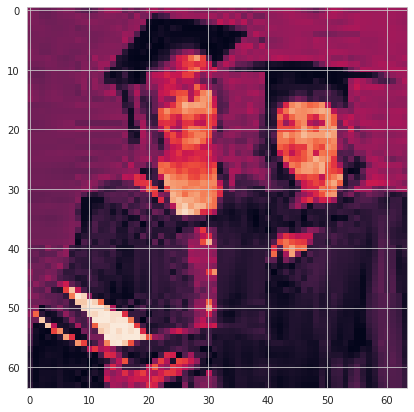

In [16]:
plt.imshow(Image_grey)

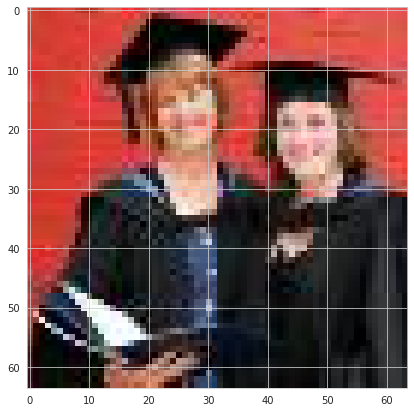

In [17]:
plt.imshow(train_data[0])

In [18]:
# SIFT
import cv2
print (cv2.__version__)
sift=cv2.SIFT_create()

# example of descriptors
keypoints, descriptors = sift.detectAndCompute(train_data[0], None)
keypoints, descriptors.astype('float64')

4.4.0


([<KeyPoint 0x7f9db03a26c0>,
  <KeyPoint 0x7f9e28f418d0>,
  <KeyPoint 0x7f9e28f41d20>,
  <KeyPoint 0x7f9e28f41e40>,
  <KeyPoint 0x7f9e28f41ab0>,
  <KeyPoint 0x7f9d7a046a20>,
  <KeyPoint 0x7f9d7a046510>,
  <KeyPoint 0x7f9d7a046390>,
  <KeyPoint 0x7f9d7a046e10>,
  <KeyPoint 0x7f9d7a046690>,
  <KeyPoint 0x7f9d7a0466c0>,
  <KeyPoint 0x7f9d7a046f60>,
  <KeyPoint 0x7f9d7a046ba0>,
  <KeyPoint 0x7f9d7a0468a0>,
  <KeyPoint 0x7f9d7a046330>,
  <KeyPoint 0x7f9d7a046ea0>,
  <KeyPoint 0x7f9d7a0463f0>,
  <KeyPoint 0x7f9d7a0460c0>,
  <KeyPoint 0x7f9d7a046090>,
  <KeyPoint 0x7f9d7a046870>,
  <KeyPoint 0x7f9d7a046b10>,
  <KeyPoint 0x7f9d7a0469c0>,
  <KeyPoint 0x7f9d7a046540>,
  <KeyPoint 0x7f9d7a0465a0>,
  <KeyPoint 0x7f9d7a0464b0>,
  <KeyPoint 0x7f9d7a046d80>,
  <KeyPoint 0x7f9d7a046f90>,
  <KeyPoint 0x7f9d7a046de0>,
  <KeyPoint 0x7f9d7a0463c0>,
  <KeyPoint 0x7f9d7a046300>,
  <KeyPoint 0x7f9d7a046fc0>,
  <KeyPoint 0x7f9dc7e5d7e0>,
  <KeyPoint 0x7f9dc7e5dba0>,
  <KeyPoint 0x7f9dc7e5dc30>,
  <KeyPoint 0x

In [81]:
def extract_descriptors(X_train, y_train):
    X, Y = [], []

    keypoints, descriptors = sift.detectAndCompute(train_data[0], None)

    descriptor_list = []
    for i in range(len(X_train)):
        keypoints, descriptors = sift.detectAndCompute(X_train[i].astype('uint8'), None)
        if descriptors is None:
            plt.imshow(X_train[i])
        else:
            descriptor_list.append(descriptors.astype('float64'))
            X.append(X_train[i])
            Y.append(y_train[i])
    
    descriptor_vstack = np.array(descriptor_list[0])
    for remaining in descriptor_list[1:]:
        descriptor_vstack = np.vstack((descriptor_vstack, remaining))

    return descriptor_vstack, descriptor_list, np.array(Y)

In [61]:
n_clusters = [50, 100, 200]
def create_clusters(descriptor_vstack, i):
    n_cluster = n_clusters[i]
    kmean = KMeans(n_clusters = n_cluster)
    kmean = kmean.fit_predict(descriptor_vstack).astype('int64')
    return kmean

In [74]:
def create_mega_histogram(k_means, n_cluster, descriptors_list): 
    mega_histogram = np.array([np.zeros(n_cluster) for i in range(len(descriptors_list))])
    old_count = 0
    for i in range(len(descriptors_list)):
        l = len(descriptors_list[i])
        for j in range(l):
            idx = k_means[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    return mega_histogram

In [22]:
def standardize(mega_histogram):
    scale = StandardScaler().fit(mega_histogram)
    return scale.transform(mega_histogram)

In [77]:
def bag_of_words(X, y, standard, i):
    descriptor_vstack, descriptors_list, y = extract_descriptors(X, y)
    k_means = create_clusters(descriptor_vstack, i)
    mega_histogram = create_mega_histogram(k_means, n_clusters[i], descriptors_list)
    if standard :
        return standardize(mega_histogram), y
    else :
      return mega_histogram, y

In [85]:
# Classification

scores_ppn, scores_NB, scores_rndf, scores_mlp = [], [], [], []

for i in range(len(n_clusters)):
    label = str(n_clusters[i])

    prepro = lambda X,y : bag_of_words(X,y,False,i)

    times['bow ppn ' + label] = time()
    ppn = create_perceptron(train_gen, prepro)
    times['bow ppn ' + label] = time() - times['bow ppn ' + label]
    y_pred = ppn.predict(prepro(X_test, y_test)[0])
    scores_ppn.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Perceptron confusion matrix Bag of Words ' + label,
                          saveas="./CM__ppn_"+label)
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    times['bow nb ' + label] = time()
    NB = create_nb(train_gen, prepro) # cannot take negative values
    times['bow nb ' + label] = time() - times['bow nb ' + label]
    y_pred = NB.predict(prepro(X_test, y_test)[0])
    scores_NB.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Naive Bayes confusion matrix Bag of Words ' + label,
                          saveas="./CM__nb_"+label)
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    '''times['bow rndf ' + label] = time()
    rndf = create_rnd_forrest(train_gen, prepro)
    times['bow rndf ' + label] = time() - times['bow rndf ' + label]
    y_pred = rndf.predict(X_test)
    scores_rndf.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Random forest confusion matrix Bag of Words ' + label,
                          saveas="./CM__rndf_"+label)
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))'''

    prepro = lambda X,y : bag_of_words(X,y,True,i)

    times['bow mlp ' + label] = time()
    mlp = create_MLP(train_gen, prepro)
    times['bow mlp ' + label] = time() - times['bow mlp ' + label]
    y_pred = mlp.predict_classes(prepro(X_test, y_test)[0])
    scores_mlp.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='MLP confusion matrix Bag of Words ' + label,
                          saveas="./CM__mlp_"+label)
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    print(n_clusters[i], " done")
    
print(scores_ppn)
print(scores_NB)
print(scores_rndf)
print(scores_mlp)


Nr_data = np.arange(len(n_clusters))
plt.figure(figsize=(5,5))
plt.plot(Nr_data, scores_ppn,"--",color="orange",marker="*", linewidth=1,label="ppn")
plt.plot(Nr_data, scores_NB,"--",color="blue",marker="*", linewidth=1,label="NB")
plt.plot(Nr_data, scores_rndf,"--",color="black",marker="*", linewidth=1,label="rndf")
plt.plot(Nr_data, scores_mlp,"--",color="green",marker="*", linewidth=1,label="mlp")
plt.legend(loc="best")
plt.title("Bag of words + SIFT",fontsize=12)
plt.ylabel("accuracy",fontsize=12)
plt.xlabel("Number of clusters",fontsize=12)
labels = n_clusters
plt.xticks(Nr_data, labels,rotation=30,fontsize=11, ha="right")
plt.savefig("./Accuracy_BOW.pdf")

KeyboardInterrupt: ignored

In [ ]:
objects = times_prepro.keys()
y_pos = np.arange(len(objects))
scores = times_prepro.values()

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of preprocessing')

plt.savefig("./time_prepro.pdf")
plt.show()

objects = times.keys()
y_pos = np.arange(len(objects))
scores = times.values()

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of training')

plt.savefig("./time_training.pdf")
plt.show()

objects = times_test.keys()
y_pos = np.arange(len(objects))
scores = times_test.values()

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of preprocessing for test')

plt.savefig("./time_training_test.pdf")
plt.show()